## Image Classification and Evaluation Metrics


In [58]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, data, exposure, transform, filters, util, metrics, feature
import cv2
from scipy.signal import convolve2d
from scipy.ndimage import uniform_filter
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
import warnings
import sklearn

warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="Expected in:")
warnings.filterwarnings("ignore", message="libtorch_cpu.dylib")

print("Library versions:")
print("numpy:", np.__version__)
print("matplotlib:", plt.matplotlib.__version__)
print("cv2:", cv2.__version__)
print("pytorch:", torch.__version__)



Library versions:
numpy: 2.1.3
matplotlib: 3.10.1
cv2: 4.12.0
pytorch: 2.9.0+cu128


---

## 1. Introduction and Setup ##

Import libraries (PyTorch/TensorFlow, matplotlib, sklearn), Load dataset and visualize sample images.


In this section, I will prepare the environment to train and evaluate an image classifier.  
This will:
- Import the necessary libraries (PyTorch, matplotlib, sklearn).  
- Load a small toy image dataset.  
- Visualize sample images to understand the classification task.

Understanding your data before training is an essential first step in any machine learning workflow.


you’ll import the key libraries for deep learning, data handling, and visualization.
I will use PyTorch to build the model, matplotlib for visualization, and sklearn for performance metrics.


In [3]:
# --- Import core libraries ---
import torch
import numpy as np
# torchvision
# transforms
# DataLoader

# --- Visualization and evaluation tools ---
# matplotlib
# classification_report, confusion_matrix

# --- Check environment setup ---
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

PyTorch version: 2.9.0+cu128
CUDA available: True


In [4]:
import random

random.seed(2025)
# --- NumPy ---
np.random.seed(2025)
# --- PyTorch (CPU + GPU) ---
torch.manual_seed(2025)
torch.cuda.manual_seed(2025)

We’ll use the CIFAR-10 dataset, which contains 60,000 small 32×32 color images across 10 object categories.

In [5]:
# --- Define preprocessing transforms ---
transform = transforms.Compose([
    transforms.ToTensor(),                     # convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5),      # normalize RGB channels
                         (0.5, 0.5, 0.5))
])

# --- Load CIFAR-10 training and test sets ---
trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=transform) # torchvision CIFAR10 trainset
testset = datasets.CIFAR10(root='./data', train=False,download=True, transform=transform) # torchvision CIFAR10 testset

# --- Create data loaders ---
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2) # DataLoader
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2) # DataLoader

# --- Class labels ---
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Before training, it’s important to visually inspect your dataset.
Here I display a few sample images with their corresponding class labels.


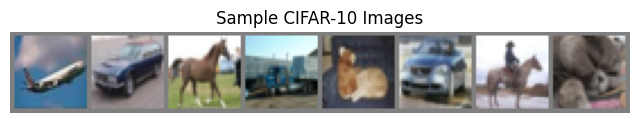

Labels: plane car   horse truck cat   car   horse cat  


In [6]:
# --- Get a batch of training images ---
dataiter = iter(trainloader)
images, labels = next(dataiter)

# --- Convert images from tensors to numpy arrays for plotting ---
def imshow(img):
    img = img * 0.5 + 0.5    # unnormalize from [-1,1] back to [0,1]
    npimg = img.numpy() # numpy format
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# --- Display a grid of sample images ---
plt.figure(figsize=(8, 4))
imshow(torchvision.utils.make_grid(images[:8], nrow=8)) # use torchvision lib
plt.title('Sample CIFAR-10 Images')
plt.show()


# --- Print corresponding class labels ---
print('Labels:', ' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))


**Comments:**

By completing this section, students will:

- Understand the dataset structure.
- Know how to prepare and visualize images for training.
- Be ready to move on to model definition and training.


---
## 2. Model Training ##

Now that the dataset is loaded, this will:
Defineing a small **Convolutional Neural Network (CNN)** with 2–3 convolutional layers.  
Training it on the CIFAR-10 dataset for a few epochs.  
Tracking **training loss and accuracy** to see how the model learns over time.

In [7]:
import torch.nn as nn
import torch.nn.functional as F

# --- Define a simple CNN ---
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        
        # Convolutional block 1: extract low-level features
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2) # MaxPool2d
        
        # Convolutional block 2: deeper feature extraction
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        
        # Fully connected layers for classification
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 classes in CIFAR-10
        
    def forward(self, x):
        # Forward pass through conv, ReLU, and pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)
        
        # Fully connected layers with ReLU and output logits
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

# --- Instantiate model, loss, and optimizer ---
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)


SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


Now we’ll train the CNN for a few epochs. We’ll compute the loss and accuracy after each epoch to monitor the learning progress.


In [8]:
from tqdm import tqdm  # progress bar utility

# --- Training loop with progress bar ---
num_epochs = 20
train_losses, train_accuracies = [], []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Wrap the DataLoader with tqdm for batch progress
    progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    
    
    for images, labels in progress_bar:
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs,labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Update statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs,1)
        total += labels.size(0)
        correct += (predicted==labels).sum().item()
        
        # Update tqdm display
        progress_bar.set_postfix(loss=loss.item())
    
    # Compute average loss and accuracy
    epoch_loss = running_loss/len(trainloader)
    epoch_acc = (correct/total)*100
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")
    

print("✅ Training complete!")

Epoch [1/20] - Loss: 1.4439, Accuracy: 47.97%


Epoch [2/20] - Loss: 1.0898, Accuracy: 61.50%


Epoch [3/20] - Loss: 0.9313, Accuracy: 67.19%


Epoch [4/20] - Loss: 0.8299, Accuracy: 70.83%


Epoch [5/20] - Loss: 0.7473, Accuracy: 73.77%


Epoch [6/20] - Loss: 0.6788, Accuracy: 76.17%


Epoch [7/20] - Loss: 0.6110, Accuracy: 78.59%


Epoch [8/20] - Loss: 0.5493, Accuracy: 80.68%


Epoch [9/20] - Loss: 0.4920, Accuracy: 82.87%


Epoch [10/20] - Loss: 0.4348, Accuracy: 84.69%


Epoch [11/20] - Loss: 0.3831, Accuracy: 86.61%


Epoch [12/20] - Loss: 0.3360, Accuracy: 88.16%


Epoch [13/20] - Loss: 0.2918, Accuracy: 89.77%


Epoch [14/20] - Loss: 0.2530, Accuracy: 91.30%


Epoch [15/20] - Loss: 0.2156, Accuracy: 92.51%


Epoch [16/20] - Loss: 0.1843, Accuracy: 93.66%


Epoch [17/20] - Loss: 0.1590, Accuracy: 94.46%


Epoch [18/20] - Loss: 0.1376, Accuracy: 95.30%


Epoch [19/20] - Loss: 0.1160, Accuracy: 96.03%


Epoch [20/20] - Loss: 0.1129, Accuracy: 96.03%
✅ Training complete!


Visualization helps you understand how your model is learning.

Plotting loss and accuracy over epochs allows you to identify underfitting, overfitting, or optimization issues.


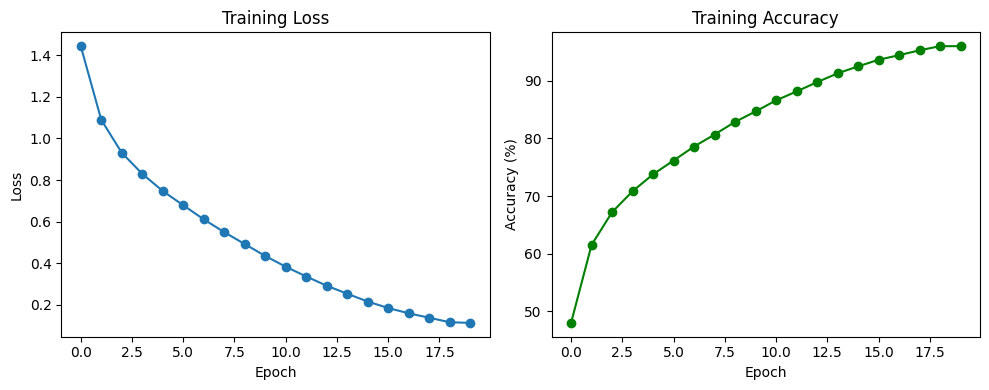

In [9]:
# --- Plot training curves ---
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(train_accuracies, marker='o', color='green')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")

plt.tight_layout()
plt.show()

---

## 3. Evaluation Metrics ##

Training accuracy alone doesn't tell the full story of model performance. A model might perform well overall but still make systematic mistakes on certain classes.

In this section, I'll compute accuracy on the training and test sets, calculate precision, recall, and F1-score manually and verify with sklearn.metrics, and prepare for confusion matrix visualization.

These metrics are essential for understanding how well the model generalizes and where it fails.


I'll first measure model accuracy on the training and test datasets to check for overfitting or underfitting.


In [10]:

# --- Define evaluation function ---
def evaluate_accuracy(model, dataloader):
    None  # set to evaluation mode (disable dropout/batchnorm)
    correct, total = 0, 0
    with torch.no_grad():  # no gradient computation
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs,1)
            total += labels.size(0)
            correct += (labels==predicted).sum().item()
    return 100 * correct / total


# --- Compute accuracy on train and test data ---
train_acc = evaluate_accuracy(model, trainloader)
test_acc = evaluate_accuracy(model, testloader)

print(f"Training Accuracy: {train_acc:.2f}%")
print(f"Test Accuracy:     {test_acc:.2f}%")

Training Accuracy: 96.42%
Test Accuracy:     67.74%


Accuracy can be misleading when classes are imbalanced. Here I compute precision, recall, and F1-score manually from true positives, false positives, and false negatives.


In [11]:
# --- Collect predictions and ground truths for the test set ---
all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs,1)
        all_labels.extend(labels.numpy())
        all_preds.extend(predicted.numpy())

# Ensure PyTorch tensors
all_labels = torch.tensor(all_labels)
all_preds = torch.tensor(all_preds)


In [12]:

# --- Compute confusion matrix elements per class ---
num_classes = len(torch.unique(all_labels))
TP = torch.zeros(num_classes, dtype=torch.int32)
FP = torch.zeros(num_classes, dtype=torch.int32)
FN = torch.zeros(num_classes, dtype=torch.int32)

for c in range(num_classes):
    TP[c] = torch.sum((all_preds == c) & (all_labels == c))
    FP[c] = torch.sum((all_preds == c) & (all_labels != c))
    FN[c] = torch.sum((all_preds != c) & (all_labels == c))

# --- Compute metrics per class ---
precision = TP / (TP + FP + 1e-8)
recall = TP / (TP + FN + 1e-8)
f1 = 2 * precision * recall / (precision + recall + 1e-8)

print("Precision per class:", np.round(precision.numpy(), 2))
print("Recall per class:   ", np.round(recall.numpy(), 2))
print("F1 per class:       ", np.round(f1.numpy(), 2))
print()

# Average metrics (macro-averaging)
precision_macro = precision.mean().item()
recall_macro = recall.mean().item()
f1_macro = f1.mean().item()

print(f"Macro Precision: {precision_macro:.3f}")
print(f"Macro Recall:    {recall_macro:.3f}")
print(f"Macro F1:        {f1_macro:.3f}")

Precision per class: [0.74 0.81 0.54 0.52 0.57 0.57 0.73 0.76 0.79 0.8 ]
Recall per class:    [0.71 0.78 0.61 0.46 0.69 0.55 0.77 0.72 0.77 0.71]
F1 per class:        [0.72 0.8  0.57 0.49 0.62 0.56 0.75 0.74 0.78 0.76]

Macro Precision: 0.682
Macro Recall:    0.677
Macro F1:        0.678


In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# --- Compute metrics using sklearn (macro = average over classes) ---
precision_sklearn = precision_score(all_labels, all_preds, average='macro')
recall_sklearn = recall_score(all_labels, all_preds, average='macro')
f1_sklearn = f1_score(all_labels, all_preds, average='macro')

print(f"Sklearn Precision (macro): {precision_sklearn:.3f}")
print(f"Sklearn Recall (macro):    {recall_sklearn:.3f}")
print(f"Sklearn F1-score (macro):  {f1_sklearn:.3f}")

# --- Print detailed per-class report ---
print("\nDetailed Classification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))

Sklearn Precision (macro): 0.682
Sklearn Recall (macro):    0.677
Sklearn F1-score (macro):  0.678

Detailed Classification Report:
              precision    recall  f1-score   support

       plane       0.74      0.71      0.72      1000
         car       0.81      0.78      0.80      1000
        bird       0.54      0.61      0.57      1000
         cat       0.52      0.46      0.49      1000
        deer       0.57      0.69      0.62      1000
         dog       0.57      0.55      0.56      1000
        frog       0.73      0.77      0.75      1000
       horse       0.76      0.72      0.74      1000
        ship       0.79      0.77      0.78      1000
       truck       0.80      0.71      0.76      1000

    accuracy                           0.68     10000
   macro avg       0.68      0.68      0.68     10000
weighted avg       0.68      0.68      0.68     10000



---

## 4. Experiments ##

In this section, I will explore how data characteristics and augmentation affect classification performance.

This will:
Compareing model performance on **balanced vs. imbalanced subsets** of the dataset.  
Evaluateing how **data augmentation**  impacts model robustness.

These experiments help you understand why dataset design and augmentation strategies are critical in real world AI systems.


In [22]:
from torch.utils.data import Subset

# --- Select a few classes to keep things small ---
selected_classes = [0, 1, 2, 3]  # plane, car, bird, cat

# --- Get indices for each selected class ---
indices_by_class = {c:np.where(np.array(trainset.targets)==c)[0] for c in selected_classes}

# --- Create a balanced subset (equal samples per class) ---
n_samples = 500
balanced_indices = np.concatenate([indices_by_class[c][:n_samples] for c in selected_classes])

# --- Create an imbalanced subset (one class dominates) ---
imbalanced_indices = np.concatenate([
    indices_by_class[0][:1000],    # plane 1000
    indices_by_class[1][:300],    # car 300
    indices_by_class[2][:200],    # bird 200
    indices_by_class[3][:500],    # cat 500
])

# --- Subset datasets ---
balanced_subset = Subset(trainset,balanced_indices)
imbalanced_subset = Subset(trainset,imbalanced_indices)

# --- Create dataloaders ---
balanced_loader = DataLoader(balanced_subset, batch_size=16, shuffle=True)
imbalanced_loader = DataLoader(imbalanced_subset, batch_size=16, shuffle=True)

print(f"Balanced subset size:   {len(balanced_subset)}")
print(f"Imbalanced subset size: {len(imbalanced_subset)}")

Balanced subset size:   2000
Imbalanced subset size: 2000


#### Train and Evaluate on Balanced vs. Imbalanced Sets

Now we train the same CNN `SimpleCNN` on both balanced and imbalanced training subsets, then evaluate their performance on a common test set to see how class imbalance impacts generalization.


In [23]:
# --- Define a quick training utility function ---
def quick_train(model, dataloader, epochs=3):
    """Train a small CNN for a few epochs and return the trained model."""
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    model.train()
    
    for epoch in range(epochs):
        running_loss, correct, total = 0.0, 0, 0
        
        # Wrap the DataLoader with tqdm for batch progress
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        
        for images, labels in progress_bar:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs,labels)
            loss.backward() # backward
            optimizer.step() # optimizer
            
            # Update metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs,1)
            total += labels.size(0)
            correct += (predicted==labels).sum().item()
        
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Loss: {running_loss/len(dataloader):.3f} | "
              f"Accuracy: {100*correct/total:.2f}%")
    
    return model

In [24]:
# --- Train on the balanced dataset ---
print("\n🔹 Training on Balanced Dataset")
balanced_model = SimpleCNN()
balanced_model = quick_train(balanced_model, balanced_loader, epochs=15)

# --- Train on the imbalanced dataset ---
print("\n🔸 Training on Imbalanced Dataset")
imbalanced_model = SimpleCNN()
imbalanced_model = quick_train(imbalanced_model, imbalanced_loader, epochs=15)


🔹 Training on Balanced Dataset


Epoch 1/15 - Loss: 1.166 | Accuracy: 50.60%


Epoch 2/15 - Loss: 0.819 | Accuracy: 67.25%


Epoch 3/15 - Loss: 0.671 | Accuracy: 73.60%


Epoch 4/15 - Loss: 0.642 | Accuracy: 74.00%


Epoch 5/15 - Loss: 0.537 | Accuracy: 78.90%


Epoch 6/15 - Loss: 0.491 | Accuracy: 81.05%


Epoch 7/15 - Loss: 0.446 | Accuracy: 82.90%


Epoch 8/15 - Loss: 0.388 | Accuracy: 84.90%


Epoch 9/15 - Loss: 0.344 | Accuracy: 87.10%


Epoch 10/15 - Loss: 0.280 | Accuracy: 90.10%


Epoch 11/15 - Loss: 0.247 | Accuracy: 91.00%


Epoch 12/15 - Loss: 0.185 | Accuracy: 94.00%


Epoch 13/15 - Loss: 0.155 | Accuracy: 95.00%


Epoch 14/15 - Loss: 0.120 | Accuracy: 96.70%


Epoch 15/15 - Loss: 0.109 | Accuracy: 96.40%

🔸 Training on Imbalanced Dataset


Epoch 1/15 - Loss: 0.935 | Accuracy: 64.30%


Epoch 2/15 - Loss: 0.643 | Accuracy: 75.70%


Epoch 3/15 - Loss: 0.555 | Accuracy: 80.25%


Epoch 4/15 - Loss: 0.482 | Accuracy: 82.10%


Epoch 5/15 - Loss: 0.407 | Accuracy: 85.40%


Epoch 6/15 - Loss: 0.365 | Accuracy: 87.85%


Epoch 7/15 - Loss: 0.307 | Accuracy: 89.00%


Epoch 8/15 - Loss: 0.253 | Accuracy: 91.35%


Epoch 9/15 - Loss: 0.208 | Accuracy: 92.65%


Epoch 10/15 - Loss: 0.175 | Accuracy: 94.65%


Epoch 11/15 - Loss: 0.133 | Accuracy: 95.65%


Epoch 12/15 - Loss: 0.097 | Accuracy: 96.50%


Epoch 13/15 - Loss: 0.069 | Accuracy: 97.90%


Epoch 14/15 - Loss: 0.049 | Accuracy: 98.85%


Epoch 15/15 - Loss: 0.036 | Accuracy: 99.10%


#### Evaluate Both Models on the Same Test Set

To fairly compare generalization, we evaluate both trained models on the same test data. This reveals how imbalance affects overall accuracy and per-class performance.


In [25]:
n_samples = 200
indices_by_class_test = {c: np.where(np.array(testset.targets) == c)[0] for c in selected_classes}
balanced_indices_test = np.concatenate([indices_by_class_test[c][:n_samples] for c in selected_classes])
balanced_subset_test = Subset(testset, balanced_indices_test)
sub_testloader = DataLoader(balanced_subset_test, batch_size=8, shuffle=False, num_workers=2)


In [26]:
def evaluate_model(model, dataloader, name="Model"):
    """Compute overall test accuracy."""
    model.eval()
    correct, total = 0, 0
    all_labels, all_preds = [], []
    
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs,1)
            total += labels.size(0)
            correct += (predicted==labels).sum().item()
            all_labels.extend(labels.numpy())
            all_preds.extend(predicted.numpy())
    
    acc = 100 * correct / total
    print(f"{name} - Test Accuracy: {acc:.2f}%")
    return all_labels, all_preds, acc

# --- Evaluate both models on test set ---
labels_bal, preds_bal, acc_bal = evaluate_model(balanced_model, sub_testloader, "Balanced Model")
labels_imb, preds_imb, acc_imb = evaluate_model(imbalanced_model, sub_testloader, "Imbalanced Model")

Balanced Model - Test Accuracy: 72.38%
Imbalanced Model - Test Accuracy: 70.25%


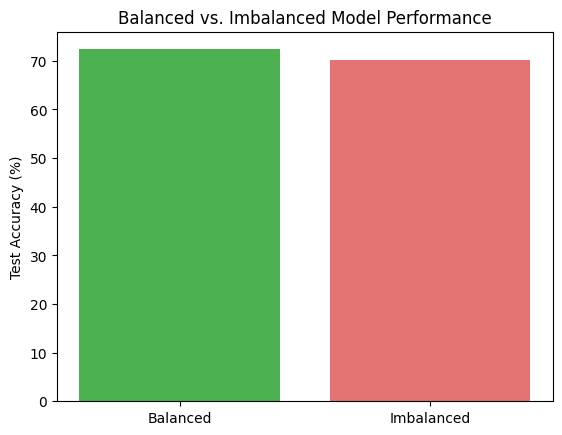

In [27]:
# --- Plot comparison ---
plt.bar(["Balanced", "Imbalanced"], [acc_bal, acc_imb], color=["#4CAF50", "#E57373"])
plt.ylabel("Test Accuracy (%)")
plt.title("Balanced vs. Imbalanced Model Performance")
plt.show()

Data augmentation artificially expands the dataset by applying random transformations like rotations, flips, and noise. This improves robustness and reduces overfitting.


In [28]:
import torchvision.transforms as transforms

# --- Define augmentation transforms ---
augment_transform = transforms.Compose([
    transforms.RandomRotation(20),      # rotate image randomly up to ±20 degrees
    transforms.RandomHorizontalFlip(),      # randomly flip horizontally
    transforms.ColorJitter(brightness=0.3),      # vary brightness
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# --- Create augmented dataset ---
augmented_trainset = datasets.CIFAR10(root='./data',train=True,download=True,transform=augment_transform)
augmented_loader = DataLoader(augmented_trainset, batch_size=32, shuffle=True)

# --- Train a new CNN on augmented data ---
print("\nTraining with Data Augmentation")
aug_model = SimpleCNN()
aug_model = quick_train(aug_model, augmented_loader, epochs=num_epochs)


Training with Data Augmentation


Epoch 1/20 - Loss: 1.489 | Accuracy: 46.54%


Epoch 2/20 - Loss: 1.210 | Accuracy: 57.01%


Epoch 3/20 - Loss: 1.099 | Accuracy: 60.99%


Epoch 4/20 - Loss: 1.040 | Accuracy: 63.16%


Epoch 5/20 - Loss: 0.990 | Accuracy: 64.90%


Epoch 6/20 - Loss: 0.958 | Accuracy: 66.19%


Epoch 7/20 - Loss: 0.930 | Accuracy: 67.04%


Epoch 8/20 - Loss: 0.906 | Accuracy: 68.01%


Epoch 9/20 - Loss: 0.886 | Accuracy: 68.56%


Epoch 10/20 - Loss: 0.869 | Accuracy: 69.13%


Epoch 11/20 - Loss: 0.854 | Accuracy: 69.77%


Epoch 12/20 - Loss: 0.843 | Accuracy: 70.27%


Epoch 13/20 - Loss: 0.827 | Accuracy: 70.84%


Epoch 14/20 - Loss: 0.814 | Accuracy: 70.97%


Epoch 15/20 - Loss: 0.802 | Accuracy: 71.71%


Epoch 16/20 - Loss: 0.794 | Accuracy: 71.88%


Epoch 17/20 - Loss: 0.790 | Accuracy: 72.17%


Epoch 18/20 - Loss: 0.773 | Accuracy: 72.90%


Epoch 19/20 - Loss: 0.771 | Accuracy: 72.78%


Epoch 20/20 - Loss: 0.763 | Accuracy: 72.96%


#### Add Random Noise to Test Images

To test robustness, we can evaluate how the trained models handle noisy inputs.


In [29]:
# --- Function to evaluate a model on the full test set ---
def evaluate_on_testloader(model, dataloader, name="Model"):
    """Evaluate model accuracy on the entire test set."""
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    print(f"{name} - Test Accuracy: {acc:.2f}%")
    return acc

# --- Evaluate both models on the test set ---
print("✅ Evaluating Models on Test Set...")
acc_base = evaluate_on_testloader(model, testloader, name="Baseline Model")
acc_aug = evaluate_on_testloader(aug_model, testloader, name="Augmented Model")

✅ Evaluating Models on Test Set...
Baseline Model - Test Accuracy: 67.74%
Augmented Model - Test Accuracy: 72.69%


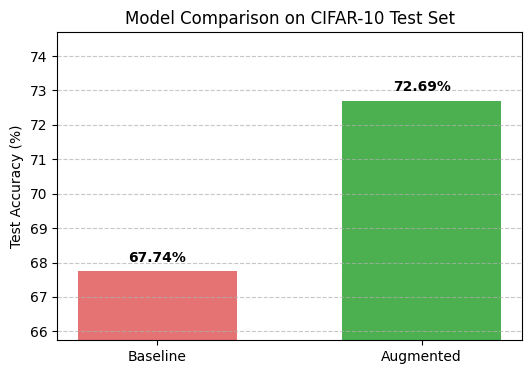

In [30]:
# --- Compare results visually ---
plt.figure(figsize=(6, 4))
bars = plt.bar(["Baseline", "Augmented"], [acc_base, acc_aug],
               color=["#E57373", "#4CAF50"], width=0.6)

plt.ylabel("Test Accuracy (%)")
plt.ylim(min(acc_base, acc_aug)-2, max(acc_base, acc_aug)+2)  # focus on a suitable accuracy range
plt.title("Model Comparison on CIFAR-10 Test Set")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# --- Add numeric accuracy labels on top of each bar ---
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.2,
             f"{height:.2f}%", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7411765..0.8352941].
Clipping input data to the valid 

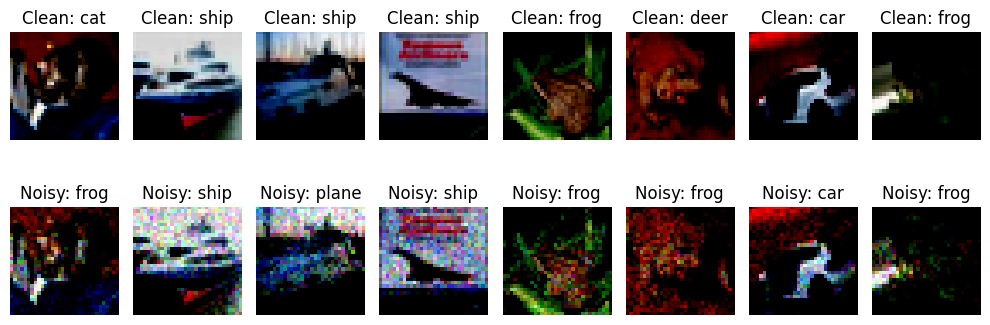

In [34]:
from skimage.util import random_noise


# --- Take a batch of test images and add noise ---
dataiter = iter(testloader)
images, labels = next(dataiter)
noisy_images = torch.tensor(random_noise(images.numpy(), mode='gaussian', var=0.02), dtype=torch.float32)

# --- Compare model predictions ---
model.eval()
outputs_clean = model(images)
outputs_noisy = model(noisy_images)

_, pred_clean = torch.max(outputs_clean,1)
_, pred_noisy = torch.max(outputs_noisy,1)


# --- Display a few comparisons ---
fig, axes = plt.subplots(2, 8, figsize=(10, 4))
for i in range(8):
    axes[0, i].imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
    axes[0, i].set_title(f"Clean: {classes[pred_clean[i]]}")
    axes[0, i].axis("off")
    
    axes[1, i].imshow(np.transpose(noisy_images[i].numpy(), (1, 2, 0)))
    axes[1, i].set_title(f"Noisy: {classes[pred_noisy[i]]}")
    axes[1, i].axis("off")
plt.tight_layout()
plt.show()

<u>**Reflection**</u>

- How does training on imbalanced data affect model accuracy across classes?  
- What improvements do you observe when using data augmentation?  
- Why does augmentation make models more robust to noise and distortions?  
- In a real-world scenario, how would you handle a severely imbalanced dataset?


---

## Additional Analysis ##

In this final section, I'll extend and analyze the CNN models by modifying the CNN architecture and observing how performance changes, training on a binary classification subset to explore precision-recall trade-offs, and discussing why high accuracy doesn't always mean good performance.

These analyses will help connect architectural design, dataset setup, and metric interpretation.


Here I'll modify the CNN by adding dropout layers and changing filter sizes. I'll compare the model’s performance before and after modification to see the effect on overfitting and generalization.


In [35]:
# --- Define a modified CNN with dropout and larger filters ---
class ModifiedCNN(nn.Module):
    def __init__(self):
        super(ModifiedCNN, self).__init__()
        
        # Larger kernels and dropout regularization
        self.conv1 = nn.Conv2d(3,32,kernel_size=4,padding=2) # Conv2d
        self.pool = nn.MaxPool2d(2,2)  # MaxPool2d
        self.conv2 = nn.Conv2d(32,64,kernel_size=4,padding=2) # Conv2d
        self.dropout = nn.Dropout(0.5)  # Dropout - helps prevent overfitting 
        self.fc1 = nn.Linear(64*8*8,256) # Linear
        self.fc2 = nn.Linear(256,10) # Linear
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # pool conv1
        x = self.pool(F.relu(self.conv2(x))) # pool conv2
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(F.relu(self.fc1(x))) # dropout
        x = self.fc2(x) # fc2
        return x

# --- Train and evaluate the modified CNN ---
mod_model = ModifiedCNN()
print("Training Modified CNN (with Dropout & Larger Filters):")
mod_model = quick_train(mod_model, trainloader, epochs=num_epochs)

# --- Evaluate on test set ---
_, _, acc_mod = evaluate_model(mod_model, testloader, name="Modified CNN")

Training Modified CNN (with Dropout & Larger Filters):


Epoch 1/20 - Loss: 1.465 | Accuracy: 46.93%


Epoch 2/20 - Loss: 1.112 | Accuracy: 60.77%


Epoch 3/20 - Loss: 0.971 | Accuracy: 65.97%


Epoch 4/20 - Loss: 0.874 | Accuracy: 69.25%


Epoch 5/20 - Loss: 0.802 | Accuracy: 71.75%


Epoch 6/20 - Loss: 0.737 | Accuracy: 74.12%


Epoch 7/20 - Loss: 0.681 | Accuracy: 75.74%


Epoch 8/20 - Loss: 0.632 | Accuracy: 77.40%


Epoch 9/20 - Loss: 0.592 | Accuracy: 79.03%


Epoch 10/20 - Loss: 0.548 | Accuracy: 80.32%


Epoch 11/20 - Loss: 0.515 | Accuracy: 81.39%


Epoch 12/20 - Loss: 0.478 | Accuracy: 82.68%


Epoch 13/20 - Loss: 0.451 | Accuracy: 83.57%


Epoch 14/20 - Loss: 0.419 | Accuracy: 84.59%


Epoch 15/20 - Loss: 0.399 | Accuracy: 85.34%


Epoch 16/20 - Loss: 0.373 | Accuracy: 86.30%


Epoch 17/20 - Loss: 0.356 | Accuracy: 87.03%


Epoch 18/20 - Loss: 0.344 | Accuracy: 87.29%


Epoch 19/20 - Loss: 0.326 | Accuracy: 87.92%


Epoch 20/20 - Loss: 0.317 | Accuracy: 88.34%


Modified CNN - Test Accuracy: 73.77%


In [47]:
# reload trainset if any errors from dataloader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)

In [48]:

# --- Choose two CIFAR-10 classes ---
binary_classes = [3, 5]
indices = np.where(np.isin(trainset.targets,binary_classes))[0]

# --- Create a binary subset ---
binary_subset = Subset(trainset,indices)
binary_loader = DataLoader(binary_subset, batch_size=32, shuffle=True)

# --- Modify dataset labels to 0/1 for binary classification ---
def relabel_binary(dataset, classes):
    for i in range(len(dataset)):
        img, label = dataset[i]
        dataset.dataset.targets[dataset.indices[i]] =0 if label==classes[0] else 1 # Modify dataset labels to 0/1

relabel_binary(binary_subset, binary_classes)


# --- Train a new CNN on binary data ---
print("\nTraining Binary Classifier (Cat vs Dog):")
binary_model = SimpleCNN()
binary_model = quick_train(binary_model, binary_loader, epochs=num_epochs)


Training Binary Classifier (Cat vs Dog):


Epoch 1/20 - Loss: 0.662 | Accuracy: 62.22%


Epoch 2/20 - Loss: 0.576 | Accuracy: 70.36%


Epoch 3/20 - Loss: 0.530 | Accuracy: 73.54%


Epoch 4/20 - Loss: 0.502 | Accuracy: 75.42%


Epoch 5/20 - Loss: 0.477 | Accuracy: 77.03%


Epoch 6/20 - Loss: 0.448 | Accuracy: 78.51%


Epoch 7/20 - Loss: 0.417 | Accuracy: 80.29%


Epoch 8/20 - Loss: 0.389 | Accuracy: 82.14%


Epoch 9/20 - Loss: 0.363 | Accuracy: 83.25%


Epoch 10/20 - Loss: 0.320 | Accuracy: 85.90%


Epoch 11/20 - Loss: 0.287 | Accuracy: 87.77%


Epoch 12/20 - Loss: 0.260 | Accuracy: 88.80%


Epoch 13/20 - Loss: 0.225 | Accuracy: 90.67%


Epoch 14/20 - Loss: 0.189 | Accuracy: 92.41%


Epoch 15/20 - Loss: 0.163 | Accuracy: 93.61%


Epoch 16/20 - Loss: 0.132 | Accuracy: 95.32%


Epoch 17/20 - Loss: 0.100 | Accuracy: 96.53%


Epoch 18/20 - Loss: 0.087 | Accuracy: 96.87%


Epoch 19/20 - Loss: 0.063 | Accuracy: 97.97%


Epoch 20/20 - Loss: 0.058 | Accuracy: 98.14%


#### Evaluate Binary Model and Analyse Metric Trade-Offs


In [49]:
# --- Create a binary test subset ---
test_indices = np.where(np.isin(testset.targets,[3,5]))[0]
binary_testset = Subset(testset,test_indices)
binary_testloader = DataLoader(binary_testset, batch_size=32, shuffle=False)


In [50]:
# --- Relabel test subset to 0/1 for binary classification ---
relabel_binary(binary_testset, binary_classes)

Binary Model - Test Accuracy: 74.80%
Accuracy:  74.80%
Precision: 0.732
Recall:    0.782
F1-Score:  0.756


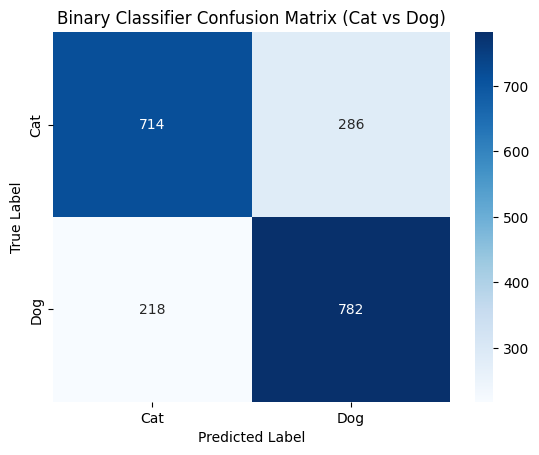

In [59]:
import seaborn as sns


# --- Evaluate the trained binary model ---
labels_bin, preds_bin, acc_bin = evaluate_model(binary_model,binary_testloader,name="Binary Model") # evaluate_model

# --- Compute precision, recall, and F1-score ---
precision = precision_score(labels_bin,preds_bin)
recall = recall_score(labels_bin,preds_bin)
f1 = f1_score(labels_bin,preds_bin)

print(f"Accuracy:  {acc_bin:.2f}%")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-Score:  {f1:.3f}")

# --- Visualize confusion matrix ---
cm = sklearn.metrics.confusion_matrix(labels_bin, preds_bin) # confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Binary Classifier Confusion Matrix (Cat vs Dog)")
plt.show()

